# Acquiring and Preprocessing Movie Data from IMDb

In this notebook, I walk through the process of acquiring, cleaning, and preparing data from the Internet Movie Database (IMDb). IMDb is a rich source of information on movies and the people who work on them—covering the entire industry dating back to 1900. By the end of this notebook, we will have a structured dataset that covers all movies released between 2000 and 2024. This dataset can be used for understanding the factors that contribute to a movie's success, or identifying trends in the movie industry.

# Data Acquisition

In this section, we access IMDb’s title.basics dataset directly from their server. This ensure we works with the most up-to-date information available. The dataset contains essential information about movies, including movie IDs, release years, and genres.

In [14]:
# import libraries 
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from wordcloud import WordCloud # data visualization using wordcloud
from collections import Counter # data visualization

In [3]:
# Define URL for IMDB movie data
url_title_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'

# Load the data directly from IMDB server
title_basics = pd.read_csv(url_title_basics, sep='\t', compression='gzip', low_memory=False)

# Exploring the Data Structure

Now that we have loaded the data, we take a closer look at its structure. We examine the first few rows, the shape of the dataset, and the distribution of key columns like `titleType`, `isAdult`, and `startYear`. This helps us decide how to filter and preprocess the data.

In [4]:
# Understanding the data structure
print(title_basics.head())
print("Shape of the dataset:", title_basics.shape)

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              5  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1                     Short  
Shape of the dataset: (11526095, 9)


In the movie data, each row is a movie and the columns contain information on the movie such as the title, the year it was released, the runtime, the genres, etc.

In [5]:
# Analyze the distribution of values in titleType, isAdult, startYear
for col in ['titleType', 'isAdult', 'startYear']:
    print(f"Distribution of values for {col}:")
    print(title_basics[col].value_counts())

Distribution of values for titleType:
titleType
tvEpisode       8865477
short           1049806
movie            709482
video            307606
tvSeries         278512
tvMovie          150234
tvMiniSeries      60442
tvSpecial         51646
videoGame         42299
tvShort           10590
tvPilot               1
Name: count, dtype: int64
Distribution of values for isAdult:
isAdult
0       11152948
1         372322
1978         130
1985          83
1980          66
1979          63
1984          41
1974          33
1982          32
1972          29
2015          28
1983          25
1966          25
1968          24
2016          20
1977          20
1981          18
1973          18
1976          18
1975          18
2017          17
1986          17
1987          13
1967           9
2018           9
2020           9
2013           8
2023           7
2019           7
1969           7
2014           6
1988           5
2024           4
1970           3
1971           2
2022           2
\N    

# Data Cleaning and Filtering

In this step, we convert key columns to numeric types and filter the dataset to include only movies released between 2000 and 2024. We also remove pornographic movies because they represent a niche market with a lot of stigma attached to it and thus there is not a lot of information available on them on IMDb.

In [6]:
# Convert startYear and isAdult to numeric
title_basics['startYear'] = pd.to_numeric(title_basics['startYear'], errors='coerce')
title_basics['isAdult'] = pd.to_numeric(title_basics['isAdult'], errors='coerce')

# Filter the data to include only movies that is not adult and has a start year between 2000 and 2024
movies_2000_2024 = title_basics[
    (title_basics['titleType'] == 'movie') & 
    (title_basics['isAdult'] == 0) & 
    (title_basics['startYear'] >= 2000) & (title_basics['startYear'] <= 2024)
    ]

# Display the unique genres in the dataset
set(
    genre.strip() 
    for genres in movies_2000_2024['genres'].dropna() 
    for genre in genres.split(',')
)

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western',
 '\\N'}

In [ ]:
# Remove rows where the genres column contains any of the unwanted genres
excluded_genres = 'Game-Show|News|Reality-TV|Talk-Show|Adult'
movies_2000_2024 = movies_2000_2024[~movies_2000_2024['genres'].str.contains(excluded_genres, regex=True, na=False)]

# Convert genres to strings
movies_2000_2024['genres'] = movies_2000_2024['genres'].astype(str)

# Replace the exact string "['\N']" with NaN
movies_2000_2024['genres'] = movies_2000_2024['genres'].replace(r'\N', np.nan)

# Replace the exact string "['\N']" with NaN in runtimeMinutes
movies_2000_2024['runtimeMinutes'] = movies_2000_2024['runtimeMinutes'].replace(r'\N', np.nan)

# Convert runtimeMinutes to numeric
movies_2000_2024['runtimeMinutes'] = pd.to_numeric(movies_2000_2024['runtimeMinutes'], errors='coerce')

# Convert StartYear to integer
movies_2000_2024['startYear'] = movies_2000_2024['startYear'].astype(int)

# Drop columns titleType, isAdult, endYear
movies_2000_2024 = movies_2000_2024.drop(columns=['titleType', 'isAdult', 'endYear'])

In [7]:
# Examine the data types
movies_2000_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338843 entries, 0 to 338843
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          338843 non-null  object 
 1   primaryTitle    338841 non-null  object 
 2   originalTitle   338841 non-null  object 
 3   startYear       338843 non-null  int64  
 4   runtimeMinutes  263479 non-null  float64
 5   genres          322209 non-null  object 
 6   averageRating   190644 non-null  float64
 7   numVotes        190644 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 23.3+ MB


In [8]:
# Count the number of unique values in each column except for the 'genres' column
movies_2000_2024.nunique()

tconst            338843
primaryTitle      304315
originalTitle     311129
startYear             25
runtimeMinutes       469
genres              1103
averageRating         91
numVotes           14762
dtype: int64

The movie data contains information on 338843 movies released across 25 years (2000 to 2024).

In [10]:
movies_2000_2024.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
11631,tt0011801,Tötet nicht mehr,Tötet nicht mehr,2019,NaN,"Action,Crime"
34794,tt0035423,Kate & Leopold,Kate & Leopold,2001,118.0,"Comedy,Fantasy,Romance"
61102,tt0062336,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,2020,70.0,Drama
67654,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
69141,tt0070596,Socialist Realism,El realismo socialista,2023,78.0,"Drama,History"


# Adding Ratings and Votes Data

We merge the IMDb title.basics data with ratings and votes data. This provides additional information on how these movies were received by the audience.

In [11]:
# Define URL for IMDB movie ratings and votes data
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

# Load the data directly from IMDB server
ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip', low_memory=False)

# Understanding the data structure
print(ratings.head())
print("Shape of the dataset:", ratings.shape)

      tconst  averageRating  numVotes
0  tt0000001            5.7      2142
1  tt0000002            5.5       290
2  tt0000003            6.4      2179
3  tt0000004            5.3       186
4  tt0000005            6.2      2913
Shape of the dataset: (1546890, 3)


In [12]:
# Examine the data types
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546890 entries, 0 to 1546889
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1546890 non-null  object 
 1   averageRating  1546890 non-null  float64
 2   numVotes       1546890 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 35.4+ MB


In [13]:
# Merge the two datasets
movies_2000_2024 = pd.merge(movies_2000_2024, ratings, on='tconst', how="left")
movies_2000_2024.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0011801,Tötet nicht mehr,Tötet nicht mehr,2019,NaN,"Action,Crime",NaN,NaN
1,tt0035423,Kate & Leopold,Kate & Leopold,2001,118.0,"Comedy,Fantasy,Romance",6.4,91466.0
2,tt0062336,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,2020,70.0,Drama,6.4,229.0
3,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.7,8268.0
4,tt0070596,Socialist Realism,El realismo socialista,2023,78.0,"Drama,History",7.1,137.0


# Data Quality Checks and Summary Statistics

We perform quality checks by identifying duplicates, examining missing values, and calculating summary statistics. These statistics provide a quick overview of data distributions and potential anomalies.

In [9]:
# Check missing values
print(movies_2000_2024.isnull().sum())

# Identify duplicates
duplicates = movies_2000_2024[movies_2000_2024.duplicated()]
print("Number of duplicate rows:", duplicates.shape[0])

tconst                 0
primaryTitle           2
originalTitle          2
startYear              0
runtimeMinutes     75364
genres             16634
averageRating     148199
numVotes          148199
dtype: int64
Number of duplicate rows: 0


Among the 338843 movies in the movie data, 78% has runtime information, 95% has genre information, 56% has rating and vote information.

In [10]:
pd.set_option('display.float_format', '{:.2f}'.format)
movies_2000_2024[['runtimeMinutes', 'averageRating', 'numVotes']].describe()

,runtimeMinutes,averageRating,numVotes
count,263479.00,190644.00,190644.00
mean,90.22,6.25,4421.54
std,191.09,1.49,39716.57
min,1.00,1.00,5.00
25%,73.00,5.30,19.00
50%,89.00,6.40,69.00
75%,101.00,7.30,387.00
max,59460.00,10.00,2995601.00


Let's create histograms to illustrate the distribution of these variables.

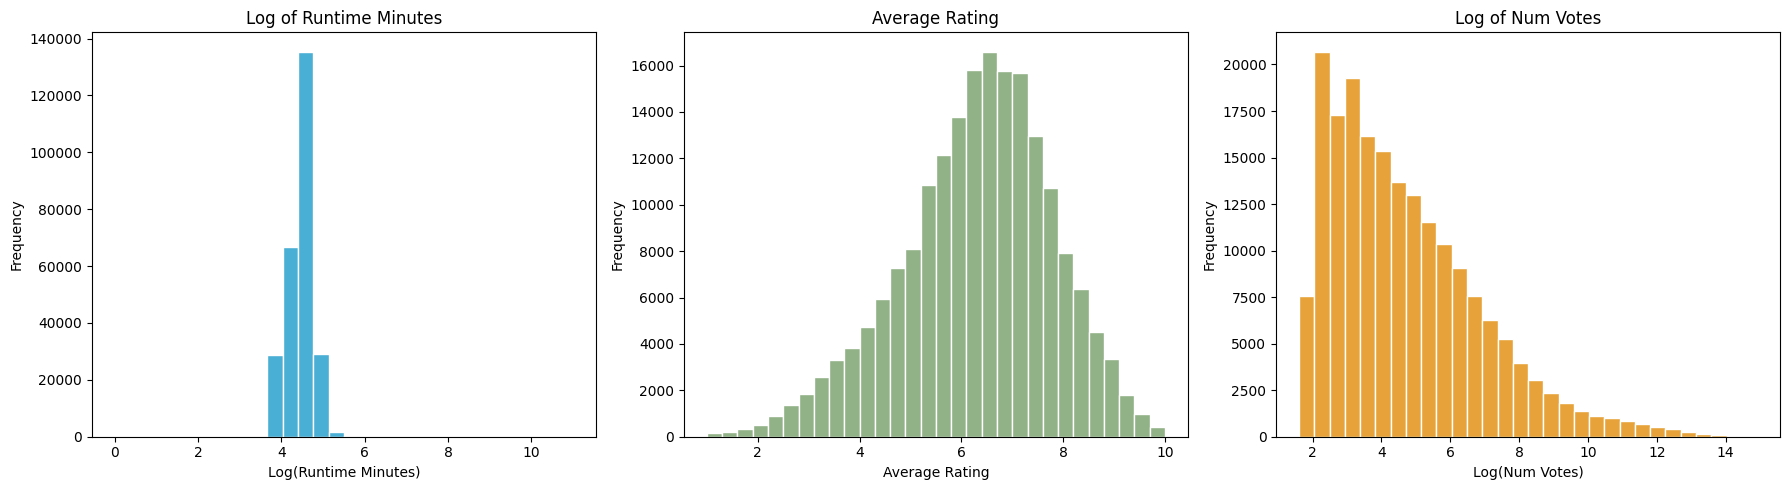

In [11]:
# Plot histograms for runtimeMinutes, averageRating, and numVotes.
# Apply log transformation to runtimeMinutes and numVotes to handle skewness.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-transform runtimeMinutes and plot histogram
runtime_log = np.log(movies_2000_2024['runtimeMinutes'].dropna())
axes[0].hist(runtime_log, bins=30, color='#4AAFD5', edgecolor='white')
axes[0].set_title('Log of Runtime Minutes')
axes[0].set_xlabel('Log(Runtime Minutes)')
axes[0].set_ylabel('Frequency')

# Plot histogram for averageRating
avg_rating = movies_2000_2024['averageRating'].dropna()
axes[1].hist(avg_rating, bins=30, color='#91B187', edgecolor='white')
axes[1].set_title('Average Rating')
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Frequency')

# Log-transform numVotes and plot histogram
votes_log = np.log(movies_2000_2024['numVotes'].dropna())
axes[2].hist(votes_log, bins=30, color='#E7A339', edgecolor='white')
axes[2].set_title('Log of Num Votes')
axes[2].set_xlabel('Log(Num Votes)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

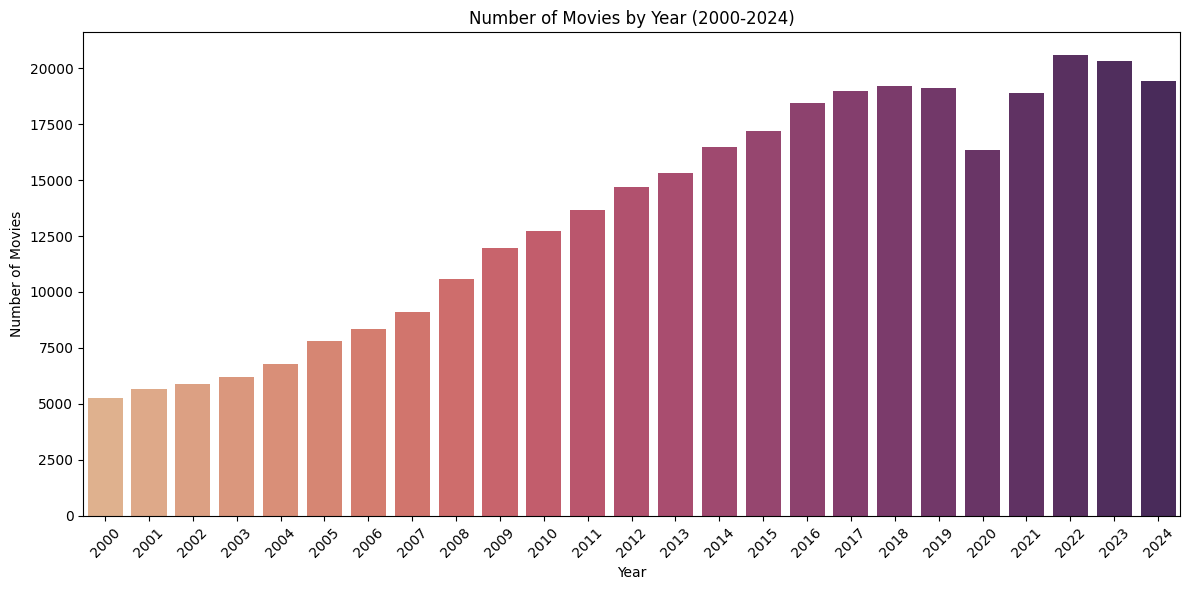

In [12]:
# Count the number of movies by year
movies_by_year = movies_2000_2024['startYear'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=movies_by_year.index, y=movies_by_year.values, hue=movies_by_year.index, palette="flare", legend=False)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Year (2000-2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

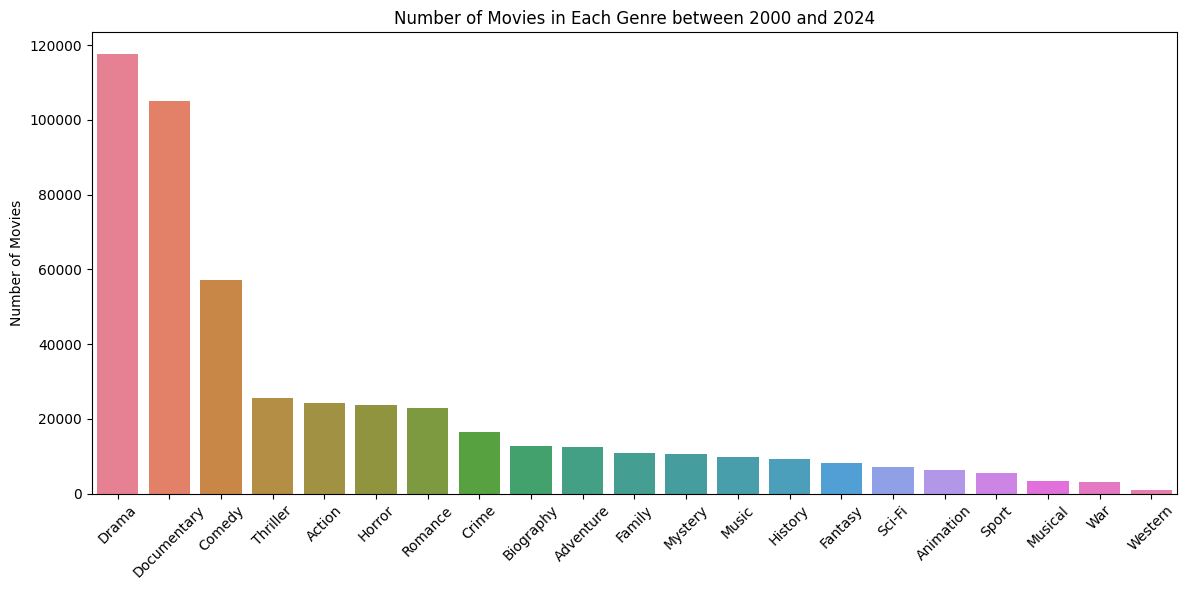

In [15]:
# Calculate genre counts by splitting the genres column
genre_counts = movies_2000_2024['genres'].str.split(',').explode().value_counts()

# Plot the genre counts in a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="husl", legend=False, hue=genre_counts.index)
plt.xlabel('')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Genre between 2000 and 2024')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, let's create a word cloud that visualizes the frequency of each genre from the dataset.

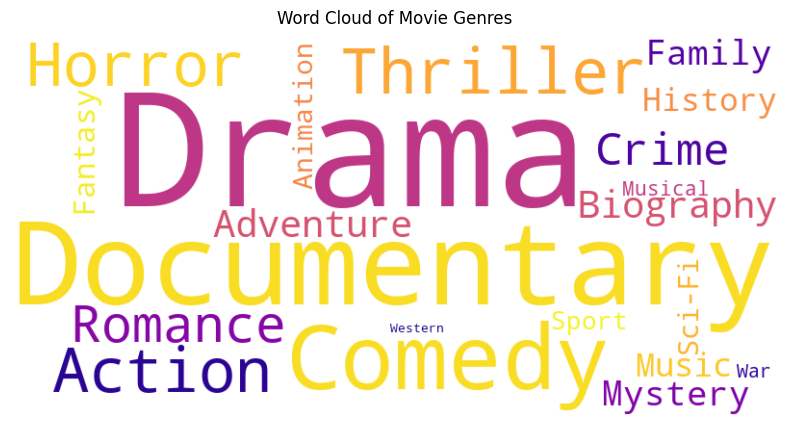

In [19]:
# Drop any missing values in the genres column
genres_series = movies_2000_2024['genres'].dropna()

# Split the comma-separated genres and flatten the list
all_genres = []
for genre_list in genres_series:
    # Split by comma and strip extra whitespace
    genres = [genre.strip() for genre in genre_list.split(',')]
    all_genres.extend(genres)

# Count the frequency of each genre using Counter
genre_counts = Counter(all_genres)

# Create a word cloud of genres based on their frequency
wc = WordCloud(width=800, height=400, background_color='white', colormap='plasma')
wc.generate_from_frequencies(genre_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Movie Genres")
plt.show()

In [16]:
# Save the cleaned dataset to a CSV file
movies_2000_2024.to_csv('movies_2000_2024.csv', index=False)